Solve heat equation on 2D domain with Dirichlet boundary conditions. 
Specify an IC, define OpInf problem and attempt a solution. Check retrieved diffusion operator!

Steady state temperature in 2D domain with length $L$ and height $H$ is given by:

$$
T=T_1\left[2 \sum_{n=1}^{\infty} \frac{1-(-1)^n}{n \pi} \frac{\operatorname{Sinh}\left[\frac{n \pi(H-y)}{L}\right]}{\operatorname{Sinh}\left[\frac{n \pi H}{L}\right]} \operatorname{Sin}\left(\frac{n \pi x}{L}\right)\right]
$$

where $T_1 = T(y=0)$

BCs are temperature values at $T(x=0)$, $T(x=L)$, $T(y=0)$, $T(y=H)$

In [2]:
import numpy as np
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import opinf

We will use the `Phi-Flow` package from TUM for this exercise. 

https://github.com/tum-pbs/PhiFlow

In [1]:
from phi.flow import *

OpInf setup

In [40]:
T1 = 100

In [51]:
values = np.zeros((50, 10))
values[0, :] = T1

In [52]:
values = tensor(values, spatial('x,y'))

In [53]:
type(values)

phi.math._tensors.NativeTensor

In [54]:
bounds = Box['x, y', 0:1, 0:1]

In [55]:
grid = CenteredGrid(values, 0, bounds, x=50, y=10)

In [56]:
grid.values

(xˢ=50, yˢ=10) float64 2.000 ± 14.000 (0e+00...1e+02)

<Figure size 1200x500 with 2 Axes>

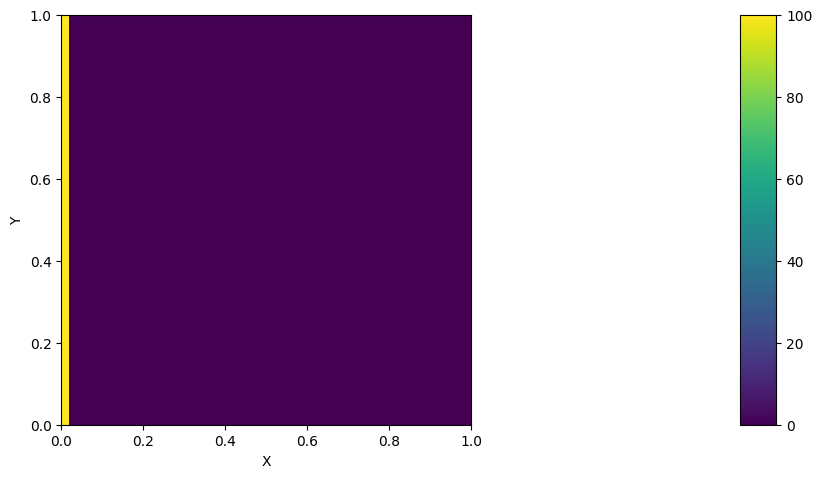

In [57]:
vis.plot(grid)